# Fraud Detection Classifier
Fraud detection is the process of detecting and preventing fraudsters from obtaining money or property through false means. It is a set of activities undertaken to detect and block the attempt of fraudsters from obtaining money or property fraudulently. Fraud detection is prevalent across banking, insurance, medical, government, and public sectors, as well as in law enforcement agencies. 

For this project, I was given a data set consisting of 21,693 banking transactions, and I was tasked with creating a classifier that could detect which new transactions are fraudulent. Each transaction included 22 unlabeled attributes, an amount, and a class. From the data, I was able to create SVM and Logistic Regression classifiers, but the results were mixed. 

In [33]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix

## 1. Load and Prepare Data

In [2]:
# Read in data
data = pd.read_csv('./assets/fraud_data.csv')
data.head()   

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.176563,0.323798,0.536927,1.047002,-0.368652,-0.728586,0.084678,-0.069246,-0.266389,0.155315,...,-0.109627,-0.341365,0.057845,0.499180,0.415211,-0.581949,0.015472,0.018065,4.67,0
1,0.681109,-3.934776,-3.801827,-1.147468,-0.735540,-0.501097,1.038865,-0.626979,-2.274423,1.527782,...,0.652202,0.272684,-0.982151,0.165900,0.360251,0.195321,-0.256273,0.056501,912.00,0
2,1.140729,0.453484,0.247010,2.383132,0.343287,0.432804,0.093380,0.173310,-0.808999,0.775436,...,-0.003802,0.058556,-0.121177,-0.304215,0.645893,0.122600,-0.012115,-0.005945,1.00,0
3,-1.107073,-3.298902,-0.184092,-1.795744,2.137564,-1.684992,-2.015606,-0.007181,-0.165760,0.869659,...,0.130648,0.329445,0.927656,-0.049560,-1.892866,-0.575431,0.266573,0.414184,62.10,0
4,-0.314818,0.866839,-0.124577,-0.627638,2.651762,3.428128,0.194637,0.670674,-0.442658,0.133499,...,-0.312774,-0.799494,-0.064488,0.953062,-0.429550,0.158225,0.076943,-0.015051,2.67,0


In [3]:
# Summarize data 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21693 entries, 0 to 21692
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      21693 non-null  float64
 1   V2      21693 non-null  float64
 2   V3      21693 non-null  float64
 3   V4      21693 non-null  float64
 4   V5      21693 non-null  float64
 5   V6      21693 non-null  float64
 6   V7      21693 non-null  float64
 7   V8      21693 non-null  float64
 8   V9      21693 non-null  float64
 9   V10     21693 non-null  float64
 10  V11     21693 non-null  float64
 11  V12     21693 non-null  float64
 12  V13     21693 non-null  float64
 13  V14     21693 non-null  float64
 14  V15     21693 non-null  float64
 15  V16     21693 non-null  float64
 16  V17     21693 non-null  float64
 17  V18     21693 non-null  float64
 18  V19     21693 non-null  float64
 19  V20     21693 non-null  float64
 20  V21     21693 non-null  float64
 21  V22     21693 non-null  float64
 22

Although attributes aren't labeled, the data set is clean: no missing values, data types are appropriate, and
fraud class is clearly defined.

In [4]:
# Calculate number of rows 
total = len(data['Class'])

# Calculate proportions for both classes 
proportions = data['Class'].value_counts() / total

proportions

Class
0    0.983589
1    0.016411
Name: count, dtype: float64

It's noteworthy that the sample is heavily skewed toward non-fraudulent instances. We'll keep this in mind
during the analysis process. 

In [5]:
# To build classifier, we first divide into X (attributes) and targets (y)
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

# Next, divide into training / test data sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## 2. Create Baseline
For comparison, we created a majority-vote classifier. Since the majority of the instances are non-fraudulent, and 
about 98% of the data is assigned to this class, we'd expect a high accuracy score. 

In [6]:
# Create dummy classifier, use most frequent class 0
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
# Make predictions with test data
y_dummy_predictions = dummy_majority.predict(X_test)

# Calculate accuracy
dummy_accuracy = accuracy_score(y_test, y_dummy_predictions)
# Calculate precision
dummy_precision = precision_score(y_test, y_dummy_predictions, zero_division=np.nan)
# Calculate recall 
dummy_recall = recall_score(y_test, y_dummy_predictions, zero_division=np.nan)

print('Accuracy: ', dummy_accuracy)
print('Precision: ', dummy_precision)
print('Recall: ', dummy_recall)

Accuracy:  0.9830383480825958
Precision:  nan
Recall:  0.0


As expected, the accuracy is over 98%. Also, the precision is undefined because the sum of false negatives and 
true positives is zero, and recall is 0.0 because there are no true positives. 

## 3. Support Vector Machine (SVM)
For the first actual classifier, we created a SVM using the default values for `kernel`, `C`, and `gamma`. 

In [7]:
# For our classifiers, we normalized the attribute data first 
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Train Support Vector Machine (SVM) model
svm = SVC().fit(X_train_scaled, y_train)
# Make predictions with training data 
svm_predicted = svm.predict(X_test_scaled)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test, svm_predicted)
# Calculate accuracy
svm_precision = precision_score(y_test, svm_predicted)
# Calculate recall 
svm_recall = recall_score(y_test, svm_predicted)

print('Accuracy: ', svm_accuracy)
print('Precision: ', svm_precision)
print('Recall: ', svm_recall)

Accuracy:  0.9961283185840708
Precision:  0.9733333333333334
Recall:  0.7934782608695652


The accuracy of 99.6% is even better than our baseline, and the high precision score indicates a low number of false positives. However, the lower recall score reflects the number of false negatives relative to the number of true positives. 
I believe this lower score is due to the highly imbalanced data set. 

## 4. Fine-Tuned SVM Classifier
To optimize the `kernel`, `C` and `gamma` hyperparameters, we used cross validation to find a better combination for these values.

In [9]:
# Hyperparameters and values iterate through 
grid_values = {'kernel': ['poly', 'rbf'], 
               'C': [0.1, 10, 100],
               'gamma':[1, 10, 100]}

# Create SVM model
svm = SVC()

# Metric to optimize over grid parameters: F-1 score
grid_svm = GridSearchCV(svm, param_grid=grid_values, scoring='f1')
# Train on models
grid_svm.fit(X_train_scaled, y_train)

# Best scoring combination of hyperparameters
params = grid_svm.best_params_

params

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

In [10]:
# Create classifier with best hyperparameters
best_svm = SVC(kernel=params['kernel'],
               C=params['C'], 
               gamma=params['gamma'])

# Train model 
best_svm.fit(X_train_scaled, y_train)

# Make predictions with training data 
best_svm_predicted = best_svm.predict(X_test_scaled)

# Calculate accuracy
best_svm_accuracy = accuracy_score(y_test, best_svm_predicted)
# Calculate accuracy
best_svm_precision = precision_score(y_test, best_svm_predicted)
# Calculate recall 
best_svm_recall = recall_score(y_test, best_svm_predicted)

print('Accuracy: ', best_svm_accuracy)
print('Precision: ', best_svm_precision)
print('Recall: ', best_svm_recall)

Accuracy:  0.9963126843657817
Precision:  0.9736842105263158
Recall:  0.8043478260869565


Using the SVM with tuned hyperparameters, our accuracy and precision were essentially the same. 
However, the recall score was slightly better. 

## 5. Logistic Regression 
For the other classifier we chose to use a logistic regression model with the default `penalty` and `C` hyperparameters.  

In [11]:
# Train Logistic Regression model
lr = LogisticRegression().fit(X_train_scaled, y_train)
# Make predictions with training data 
lr_predicted = lr.predict(X_test_scaled)

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, lr_predicted)
# Calculate accuracy
lr_precision = precision_score(y_test, lr_predicted)
# Calculate recall 
lr_recall = recall_score(y_test, lr_predicted)

print('Accuracy: ', lr_accuracy)
print('Precision: ', lr_precision)
print('Recall: ', lr_recall)

Accuracy:  0.9948377581120944
Precision:  0.9848484848484849
Recall:  0.7065217391304348


The logistic regression results were mixed. The accuracy was slightly less, but the precision score was 
better than the SVM results. The recall, however, was much lower.

## 6. Fine-Tuned Logistic Regression
To improve our logistic regression results, we again used cross validation to determine a better combination of hyperparameters. 

In [12]:
# Hyperparameters and values iterate through 
grid_values = {'penalty': ['l1', 'l2'],
               'C': [0.01, 0.1, 1, 10]}

# Create Logistic Regression model using 'liblinear' solver
lr = LogisticRegression(solver='liblinear')

# Metric to optimize over grid parameters: F-1 score
grid_lr = GridSearchCV(lr, param_grid=grid_values, scoring='f1')
# Train on models
grid_lr.fit(X_train_scaled, y_train)

# Best scoring combination of hyperparameters
params = grid_lr.best_params_

params

{'C': 10, 'penalty': 'l2'}

In [13]:
# Create classifier with best hyperparameters
best_lr = LogisticRegression(C=params['C'], 
                             penalty='l2')

# Train model 
best_lr.fit(X_train_scaled, y_train)

# Make predictions with training data 
best_lr_predicted = best_lr.predict(X_test_scaled)

# Calculate accuracy
best_lr_accuracy = accuracy_score(y_test, best_lr_predicted)
# Calculate accuracy
best_lr_precision = precision_score(y_test, best_lr_predicted)
# Calculate recall 
best_lr_recall = recall_score(y_test, best_lr_predicted)

print('Accuracy: ', best_lr_accuracy)
print('Precision: ', best_lr_precision)
print('Recall: ', best_lr_recall)

Accuracy:  0.9959439528023599
Precision:  0.9605263157894737
Recall:  0.7934782608695652


The results were again mixed. The accuracy score slightly improved, but the precision score dropped a little. 
And the recall went up significantly. 

## 7. Conclusion 
To summarize, here are the overall results of our classifiers: 

In [39]:
# Create data frame with results 
results = pd.DataFrame({'Accuracy': [dummy_accuracy, svm_accuracy, best_svm_accuracy, lr_accuracy, best_lr_accuracy],
                        'Precision': [dummy_precision, svm_precision, best_svm_precision, lr_precision, best_lr_precision],
                        'Recall': [dummy_recall, svm_recall, best_svm_recall, lr_recall, best_lr_recall]},
                       index=['Dummy', 'Default SVM', 'Best SVM', 'Default LR', 'Best LR'])
results

,Accuracy,Precision,Recall
Dummy,0.983038,NaN,0.000000
Default SVM,0.996128,0.973333,0.793478
Best SVM,0.996313,0.973684,0.804348
Default LR,0.994838,0.984848,0.706522
Best LR,0.995944,0.960526,0.793478


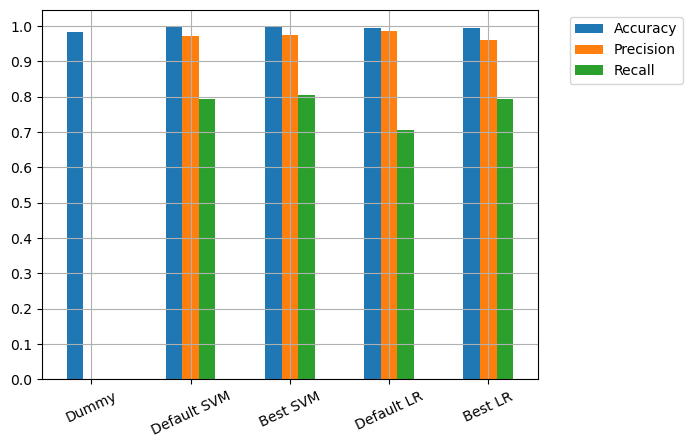

In [41]:
# Plot results 
ax = results.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()
plt.xticks(rotation = 25)
loc = matplotlib.ticker.MultipleLocator(0.1)
ax.yaxis.set_major_locator(loc)

Overall, all four of our classifiers did better than our baseline. However, accuracy may not be the best measure to 
evaluate the models, because of the heavily imbalanced data set. Using just the precision scores, the models still performed well, but the recall numbers aren't good. Since the classifier is a fraud detector, we are more concerned with false negatives (fraudulent transactions that go undetected) than false positives. Therefore, we should explore other fraud detection classifiers.  